<a href="https://colab.research.google.com/github/pen1064/Mask-Faster-R-CNN/blob/main/CNN_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install keras-tuner

     |████████████████████████████████| 98 kB 4.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
import pandas as pd
import cv2
import glob
import os
import numpy as np
from xml.etree import ElementTree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [4]:
annotation_directory = r'/content/gdrive/MyDrive/mask/annotations'
image_directory = r'/content/gdrive/MyDrive/mask/images'
cropped_directory = r'/content/gdrive/MyDrive/mask/cropped'
without_mask_directory = r'/content/gdrive/MyDrive/mask/cropped/without_mask'
mask_directory = r'/content/gdrive/MyDrive/mask/cropped/mask'
incorrect_mask_directory =  r'/content/gdrive/MyDrive/mask/cropped/mask_weared_incorrectly'

In [5]:
DATA = {k:[] for k in ['img_file', 'width', 'height', 'depth', 'name', 'xmin', 'xmax', 'ymin', 'ymax']}

for file in glob.glob(annotation_directory+'/*.xml'):
    tree = ElementTree.parse(file)
    for item in tree.iter():
        if 'size' in item.tag:
            img_dim = [int(i.text) for i in list(item)]
        if 'object' in item.tag:
            d = []
            name = item.find('name').text
            bndbox = item.find('bndbox')
            box = [int(i.text) for i in list(bndbox)]
            DATA['img_file']+= [file.split('/')[-1][:-3]+'png']
            DATA['width'] += [img_dim[0]]
            DATA['height'] += [img_dim[1]]
            DATA['depth'] += [img_dim[2]]
            DATA['name'] += [name]
            DATA['xmin'] += [box[0]]
            DATA['xmax'] += [box[2]]
            DATA['ymin'] += [box[1]]
            DATA['ymax'] += [box[3]]

In [6]:
df = pd.DataFrame(DATA)
df.head(3)

,img_file,width,height,depth,name,xmin,xmax,ymin,ymax
0,maksssksksss0.png,512,366,3,without_mask,79,109,105,142
1,maksssksksss0.png,512,366,3,with_mask,185,226,100,144
2,maksssksksss0.png,512,366,3,without_mask,325,360,90,141


In [7]:
if not os.path.isdir(cropped_directory): os.mkdir(cropped_directory)
if not os.path.isdir(without_mask_directory): os.mkdir(without_mask_directory)
if not os.path.isdir(mask_directory): os.mkdir(mask_directory)
if not os.path.isdir(incorrect_mask_directory): os.mkdir(incorrect_mask_directory) 
crop_img_files = []
for i in range(len(df)):
    image_file = os.path.join(image_directory, df.loc[i, 'img_file'])
    img = cv2.imread(image_file)
    crop_im = img[df.loc[i,'ymin']:df.loc[i,'ymax'], df.loc[i,'xmin']:df.loc[i,'xmax']]   
    crop_img_file = str(i) + '.png'
    if df.loc[i, 'name'] == 'without_mask':
        crop_img_f = os.path.join(without_mask_directory, crop_img_file)
        #cv2.imwrite(crop_img_f, crop_im)
    elif df.loc[i, 'name'] == 'with_mask':
        crop_img_f = os.path.join(mask_directory, crop_img_file)
        #cv2.imwrite(crop_img_f, crop_im)
    else:
        crop_img_f = os.path.join(incorrect_mask_directory, crop_img_file)
        #cv2.imwrite(crop_img_f, crop_im)
    crop_img_files.append(crop_img_f)

In [8]:
df['crop_img_file'] = crop_img_files

In [9]:
labels = df['name']
attributes = df.drop(['name'], axis=1).columns
Xtrain, Xtest, ytrain, ytest = train_test_split(df, labels, test_size=0.25, random_state = 33, stratify=labels)

In [10]:
data_generator = ImageDataGenerator(rescale=1/255,validation_split=0.25)

train_generator = data_generator.flow_from_dataframe(
    dataframe = Xtrain, directory = './cropped_images',
    x_col = 'crop_img_file', y_col = 'name', subset='training',
    seed=42, shuffle= True, class_mode='categorical', target_size = (60,60)
)

Found 1532 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1012 invalid image filename(s) in x_col="crop_img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [11]:
validate_generator = data_generator.flow_from_dataframe(
    dataframe = Xtrain, directory='./cropped_images', 
    x_col= 'crop_img_file', y_col = 'name', subset='validation',
    seed = 42, shuffle = True, class_mode = 'categorical', target_size=(60,60)
)

Found 510 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1012 invalid image filename(s) in x_col="crop_img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
test_image_generator = ImageDataGenerator(rescale=1/255)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe = Xtest, directory='./cropped_images', 
    x_col= 'crop_img_file', y_col = 'name',
    seed = 42, shuffle = True, class_mode = 'categorical', target_size=(60,60)
)

Found 663 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 355 invalid image filename(s) in x_col="crop_img_file". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [15]:
from kerastuner import HyperModel

class MeowHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=self.input_shape))
        model.add(layers.Conv2D(64, 3, activation='relu'))
        model.add(layers.Conv2D(128, 3, activation='relu'))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=hp.Int('dense_unit1', min_value=32, max_value=256, default=128, step=32), 
                               activation= hp.Choice('dense_activation1', values=['relu', 'tanh', 'sigmoid'], default='relu')))
        model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0, max_value=0.5, default=0.25, step=0.05)))
        model.add(layers.Dense(units=hp.Int('dense_unit2', min_value=32, max_value=256, default=128, step=32), 
                               activation= hp.Choice('dense_activation2', values=['relu', 'tanh', 'sigmoid'], default='relu')))
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=keras.optimizers.Adam(lr=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)), 
                                                      loss='categorical_crossentropy', metrics=['accuracy'])
        return model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [15]:
tuner.search(train_generator, epochs=10, validation_data=validate_generator, batch_size=32)

Trial 10 Complete [00h 26m 38s]
val_accuracy: 0.9372549057006836

Best val_accuracy So Far: 0.9725490212440491
Total elapsed time: 05h 33m 10s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_model = tuner.get_best_models()[0]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
best_model.save(r'/content/gdrive/MyDrive/mask/meow_optimizedqq.h5')

In [ ]:
tuner.results_summary()

In [24]:
test_generator.reset()
best_model = load_model(r'/content/gdrive/MyDrive/mask/meow_optimizedqq.h5')
pred=best_model.predict_generator(test_generator,steps=len(test_generator),verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


21/21 [==============================] - 177s 9s/step


In [25]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
Xtest = Xtest.reset_index()


In [26]:
correct = 0
for i in range(len(predictions)):
  if predictions[i] in Xtest.loc[i, 'name']:
     correct+=1
print(correct/len(predictions)*100)


75.56561085972851


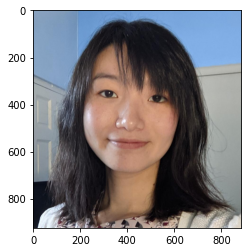

without_mask
[[0.00207778 0.46782997 0.53009224]]


In [33]:
img1 = cv2.imread(r'/content/gdrive/MyDrive/mask/test_mask1.png')
img1=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
img = cv2.resize(img1,(60,60))     # resize image to match model's expected sizing
img = img.reshape(1,60,60,3)
img = img/255
pred_val = best_model.predict(img)
for ind, v in enumerate(pred_val[0]):
  if v > 0.5: print(list(test_generator.class_indices)[ind])
print(pred_val)



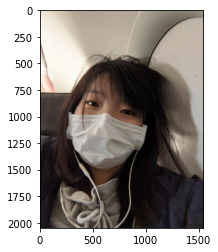

with_mask
[[3.8713284e-04 9.8811519e-01 1.1497611e-02]]


In [36]:
img2 = cv2.imread(r'/content/gdrive/MyDrive/mask/test_mask2.png')
img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.show()
img = cv2.resize(img2,(60,60))     # resize image to match model's expected sizing
img = img.reshape(1,60,60,3)
img = img/255
pred_val = best_model.predict(img)
for ind, v in enumerate(pred_val[0]):
  if v > 0.5: print(list(test_generator.class_indices)[ind])
print(pred_val)

